In [1]:
##quitar cuando acabe
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from sklearn import utils
import wandb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

pd.set_option('display.max_columns', 500)

# local modules
from utils.config import Config, Config_AE
import utils.utils as utils
import utils.plots as plots
import modelsNN.modelsNN as modelsNN

In [3]:
# If you are on drive use this:
# PATH_DEEPSF = '/content/gdrive/MyDrive/deepsf/code_JS/folder_rawdata_processing/'

# Local:
PATH_DEEPSF = 'C:/Users/joseb/Downloads/deepsf/data'

# DeepAE

In [7]:
# %%% Setting deepAE NN characteristics.
config = Config_AE()
config.get_config()        

{'batch_size': 32,
 'optimizer': 'adamW',
 'epochs': 3000,
 'learning_rate': 0.1,
 'if_wandb': False,
 'test_size': 0.2,
 'tumor_type': ['LUAD']}

In [8]:
# %%% Get the data AE
data_AE = utils.get_data_AE(PATH_DEEPSF, config)
TCGA_tpm_gn_prot_cod = data_AE.TCGA_tpm_gn_prot_cod

In [9]:
# %%% Get the model AE
model_AE = modelsNN.DeepAE(n_inputs=TCGA_tpm_gn_prot_cod.shape[1])
model_AE

DeepAE(
  (linear1): Linear(in_features=19594, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=19594, bias=True)
)

In [26]:
optimizer = utils.build_optimizer(model_AE, config.optimizer, config.learning_rate)

# # # %%% Train
history = utils.fit(config.epochs,
                    model_AE, 
                    data_AE.train_loaderAE, 
                    data_AE.val_loaderAE, 
                    optimizer=optimizer,
                    hyperparameters = config.get_config(),
                    if_wandb = config.if_wandb,
                    path = PATH_DEEPSF,
                    model_name = 'model_DeepAE_adamW.pt')

Epoch [0], loss: 10715226.0000, val_loss: 136118.9375
Epoch [1], loss: 169923.4219, val_loss: 136118.9375
Epoch [2], loss: 162843.5000, val_loss: 136324.5469
Epoch [3], loss: 149453.0938, val_loss: 136118.9375
Epoch [4], loss: 138892.4375, val_loss: 136118.9375
Epoch [5], loss: 135646.5625, val_loss: 136118.9375
Epoch [6], loss: 135646.5781, val_loss: 136118.9375
Epoch [7], loss: 135646.5469, val_loss: 136118.9375
Epoch [8], loss: 135646.5625, val_loss: 136118.9375


KeyboardInterrupt: 

In [ ]:
############################################################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################
# COSAS POR HACER 18:06 - 26/04:
# - meter código katyna plots y hacerlo en plan función. Y meterlo en utils (MEDIO)
# - meter el codigo del autoencoder en utils, modelsNN, y config. Y crear un config tb para el deepAE (HECHO)
# - HACER LO DE LOS EVENTOS DE FERNANDO.
# - Combinar ambos modelos
############################################################################################################################

In [25]:
# aquiii

import torch
import torch.nn as nn
import os

model_name = 'model_DeepAE_adamW.pt'
model = modelsNN.DeepAE(n_inputs=TCGA_tpm_gn_prot_cod.shape[1])
model

model.load_state_dict(torch.load(PATH_DEEPSF+'/'+model_name))

#We remove the last layer and freeze the learning
l3_model = nn.Sequential(*list(model.children())[:-1])
l3_model


# for param in l3_out.parameters():
#     param.requires_grad = False

torch.save(l3_model.state_dict(), os.path.join(PATH_DEEPSF, 'l3_model_DeepAE_adamW.pt')) 


DeepAE(
  (linear1): Linear(in_features=19594, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=19594, bias=True)
)

<All keys matched successfully>

Sequential(
  (0): Linear(in_features=19594, out_features=512, bias=True)
  (1): Linear(in_features=512, out_features=512, bias=True)
  (2): Linear(in_features=512, out_features=512, bias=True)
)

In [ ]:
# Ojo que tiene pintón: https://stackoverflow.com/questions/65216411/how-to-concatenate-2-pytorch-models-and-make-the-first-one-non-trainable-in-pyto

# One easy way to do that is to detach the output tensor of the model that you don't want to update and it will not 
# backprop gradient to the connected model. In your case, you can simply detach x2 tensor just before concatinating 
# with x1 in the forward function of MyEnsemble model to keep the weight of modelB unchanged.

# class MyModelA(nn.Module): # este seria el deep2hidden
#     def __init__(self):
#         super(MyModelA, self).__init__()
#         self.fc1 = nn.Linear(10, 2)
        
#     def forward(self, x):
#         x = self.fc1(x)
#         return x
    
# class MyModelB(nn.Module): # este el deepAE
#     def __init__(self):
#         super(MyModelB, self).__init__()
#         self.fc1 = nn.Linear(20, 2)
        
#     def forward(self, x):
#         x = self.fc1(x)
#         return x

# class MyEnsemble(nn.Module): # este el combinado
#     def __init__(self, modelA, modelB):
#         super(MyEnsemble, self).__init__()
#         self.modelA = modelA
#         self.modelB = modelB
#         self.classifier = nn.Linear(4, 2)
        
#     def forward(self, x1, x2):
#         x1 = self.modelA(x1)
#         x2 = self.modelB(x2)
#         x = torch.cat((x1, x2), dim=1)
#         x = self.classifier(F.relu(x))
#         return x

# # Create models and load state_dicts    
# modelA = MyModelA()
# modelB = MyModelB()
# # Load state dicts
# modelA.load_state_dict(torch.load(PATH))
# modelB.load_state_dict(torch.load(PATH)) # solo tendria que cargar los pesos del deepAE porque el otro hay que entrenarlo.

# model = MyEnsemble(modelA, modelB)
# x1, x2 = torch.randn(1, 10), torch.randn(1, 20)
# output = model(x1, x2)

# So, the new forward function should be like following:

# def forward(self, x1, x2):
#         x1 = self.modelA(x1)
#         x2 = self.modelB(x2)
#         x = torch.cat((x1, x2.detach()), dim=1)  # Detaching x2, so modelB wont be updated
#         x = self.classifier(F.relu(x))
#         return x
    

# DeepSF

In [4]:
# %%% Setting deepsf NN characteristics. (para hacer wandb hacer un bucle con la conf 
                                        #dejando fuera el data prep que solo lo llames una vez)
config = Config(optimizer='adamW',
                epochs = 100,
                if_wandb = False,
                if_toy = True,
                num_genes = 3,
                learning_rate = 1e-3)

# config =  Config()
config.get_config()

{'batch_size': 32,
 'optimizer': 'adamW',
 'modelNN': 'DeepSF_2hidden',
 'epochs': 100,
 'learning_rate': 0.001,
 'if_toy': True,
 'if_wandb': False,
 'test_size': 0.2,
 'num_genes': 3,
 'tumor_type': ['LUAD']}

In [5]:
# %%% Get the data
data_prep = utils.get_data(PATH_DEEPSF, config)

{'batch_size': 32, 'optimizer': 'adamW', 'modelNN': 'DeepSF_2hidden', 'epochs': 100, 'learning_rate': 0.001, 'if_toy': True, 'if_wandb': False, 'test_size': 0.2, 'num_genes': 3, 'tumor_type': ['LUAD']} 

Epoch [0], loss: 5.2584, val_loss: 4.5914
Epoch [1], loss: 4.3024, val_loss: 3.7309
Epoch [2], loss: 3.4274, val_loss: 2.9247
Epoch [3], loss: 2.6092, val_loss: 2.2104
Epoch [4], loss: 1.9045, val_loss: 1.6696
Epoch [5], loss: 1.3726, val_loss: 1.2644
Epoch [6], loss: 0.9778, val_loss: 0.9689
Epoch [7], loss: 0.7234, val_loss: 0.7977
Epoch [8], loss: 0.5654, val_loss: 0.6940
Epoch [9], loss: 0.4583, val_loss: 0.6220
Epoch [10], loss: 0.3989, val_loss: 0.5782
Epoch [11], loss: 0.3613, val_loss: 0.5622
Epoch [12], loss: 0.3223, val_loss: 0.5470
Epoch [13], loss: 0.3048, val_loss: 0.5205
Epoch [14], loss: 0.2877, val_loss: 0.5239
Epoch [15], loss: 0.2740, val_loss: 0.5423
Epoch [16], loss: 0.2688, val_loss: 0.5165
Epoch [17], loss: 0.2454, val_loss: 0.5233
Epoch [18], loss: 0.2372, val_lo

0.977832514517326

,gene_name,trans_name,cor_values
0,ARF5,ENST00000000233,0.933842
1,M6PR,ENST00000000412,0.956633
2,ESRRA,ENST00000000442,0.965621
3,ESRRA,ENST00000405666,0.974496
4,ESRRA,ENST00000406310,0.959512
5,ARF5,ENST00000415666,0.793974
6,ARF5,ENST00000459680,0.875241
7,ARF5,ENST00000463733,0.954044
8,ARF5,ENST00000467281,0.853219
9,ESRRA,ENST00000467987,0.980509


0.8554336461948377

,gene_name,trans_name,cor_values
0,ARF5,ENST00000000233,0.735051
1,M6PR,ENST00000000412,0.862817
2,ESRRA,ENST00000000442,0.753809
3,ESRRA,ENST00000405666,0.801840
4,ESRRA,ENST00000406310,0.383246
5,ARF5,ENST00000415666,0.037526
6,ARF5,ENST00000459680,0.237037
7,ARF5,ENST00000463733,0.486714
8,ARF5,ENST00000467281,0.448810
9,ESRRA,ENST00000467987,0.802314


C:\Users\joseb\anaconda3\envs\Cobra_python3_6\lib\site-packages\captum\_utils\gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
C:\Users\joseb\anaconda3\envs\Cobra_python3_6\lib\site-packages\captum\_utils\gradient.py:59: UserWarning: Input Tensor 1 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
C:\Users\joseb\anaconda3\envs\Cobra_python3_6\lib\site-packages\captum\attr\_core\deep_lift.py:339: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


,ENST00000000233,ENST00000000412,ENST00000000442,ENST00000405666,ENST00000406310,ENST00000415666,ENST00000459680,ENST00000463733,ENST00000467281,ENST00000467987,ENST00000468670,ENST00000489673,ENST00000536844,ENST00000537621,ENST00000539143,ENST00000539594,ENST00000540837,ENST00000541507,ENST00000543159,ENST00000543258,ENST00000543704,ENST00000543834,ENST00000543845,ENST00000544193,ENST00000544245,ENST00000545035
BMS1,-0.000980,-0.106001,-0.000375,-0.000777,-0.000962,-0.000237,-0.001255,-0.000428,-0.000528,-0.059781,-0.000244,-0.000384,0.000307,-0.000046,0.001696,2.479313e-04,-0.000279,-0.000580,-0.000189,0.000168,0.000023,0.000080,0.000549,0.001014,0.000091,-0.000347
RBMY1D,-0.000087,-0.081670,-0.000262,-0.000195,0.000035,-0.000264,-0.000128,-0.000541,-0.000252,-0.007824,0.000477,-0.000211,0.000581,0.000100,-0.000051,-9.632105e-07,0.000276,-0.000220,0.000066,0.000384,-0.000496,0.000704,0.000007,-0.000038,-0.000673,-0.000092
RBM11,0.000204,0.231980,0.000753,0.000480,-0.000823,-0.000298,-0.000229,0.000413,-0.000463,0.013034,-0.000003,0.000842,-0.001027,0.000691,0.000353,-8.756166e-05,-0.000480,0.000239,0.000151,-0.000233,-0.000288,-0.000273,-0.000522,0.001985,0.000672,-0.001122
CCT6A,-0.000046,0.018652,0.000091,-0.000001,-0.000139,-0.000061,-0.000005,-0.000053,0.000197,-0.027651,-0.000122,-0.000132,0.000129,-0.000085,-0.000063,5.902629e-04,0.000036,-0.000007,0.000195,0.000070,0.000229,-0.000029,-0.000623,-0.000134,0.000079,-0.000257
ATP5A1,0.000671,0.072610,0.000198,0.000560,0.001351,-0.000710,-0.001097,0.000207,0.001256,-0.001175,-0.000182,-0.000378,-0.000502,0.000272,0.000700,1.082692e-03,-0.000258,0.000177,-0.000074,0.000468,0.000056,0.000385,0.000461,-0.000162,0.000112,0.001271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EIF3D,-0.000250,0.008267,0.000114,0.000164,-0.000240,0.000439,-0.000991,0.000088,-0.000873,0.004446,0.000252,0.001098,-0.000060,0.000954,0.000597,-2.745811e-03,0.000148,0.000567,0.001254,0.000971,0.000210,0.001071,-0.001732,-0.000457,-0.001070,-0.000273
TRIP6,0.000781,0.154470,0.000073,0.000987,-0.000915,-0.002144,-0.000101,-0.000666,0.000260,-0.023215,-0.001056,0.000777,0.000046,-0.000049,0.001213,-5.097908e-04,-0.000114,0.000052,0.000566,-0.000352,0.000801,0.000375,-0.000190,0.001273,-0.000116,0.004538
XRN1,-0.000031,-0.286140,-0.000210,-0.000687,-0.000319,0.000786,-0.001824,0.000333,-0.001896,-0.062707,-0.000236,0.000155,-0.000081,-0.000192,-0.001120,4.235531e-05,-0.000208,-0.000416,-0.000664,-0.000366,0.001683,0.000247,0.000273,-0.000036,-0.001364,-0.000054
RBM23,0.000586,0.048042,0.000109,0.000358,0.000096,-0.001089,0.002502,-0.000964,0.000293,0.064363,0.000442,-0.000288,-0.000244,-0.000159,0.000683,9.759023e-04,-0.001870,-0.000222,-0.000503,0.000338,-0.000186,-0.000978,0.000290,0.000558,-0.000273,-0.000430


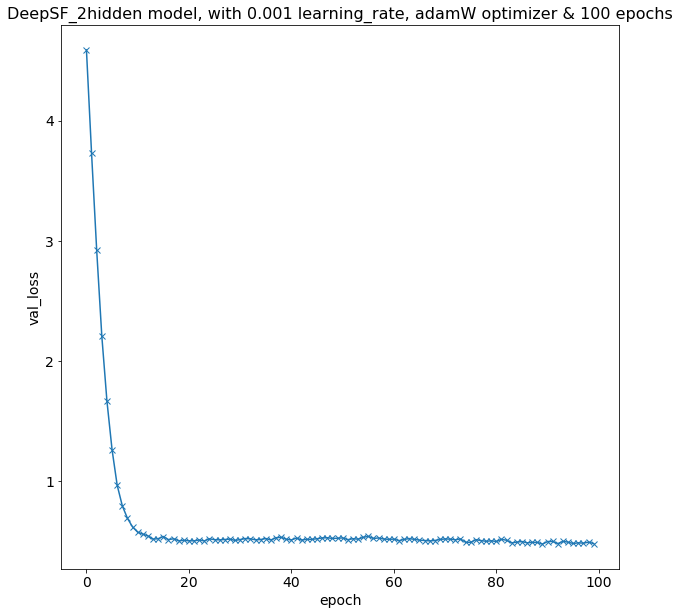

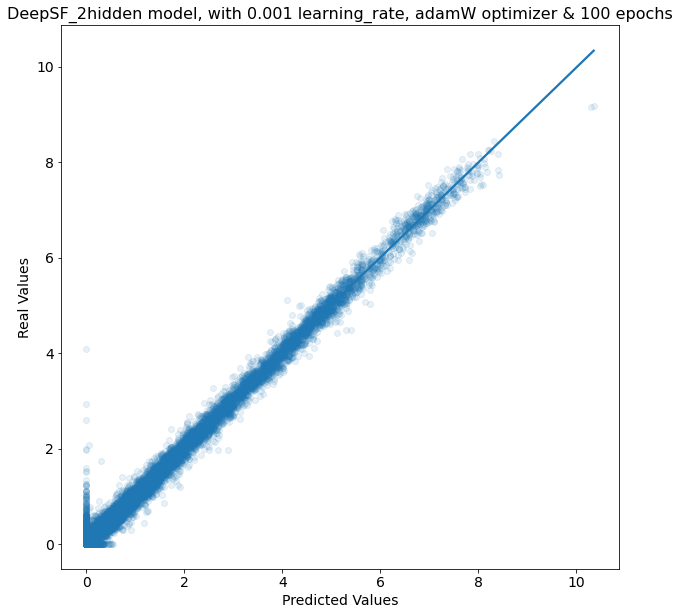

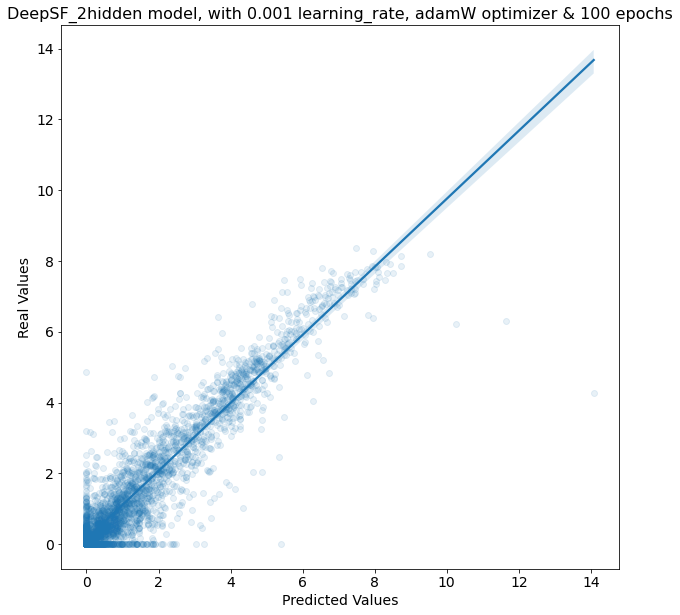

<Figure size 800x800 with 0 Axes>

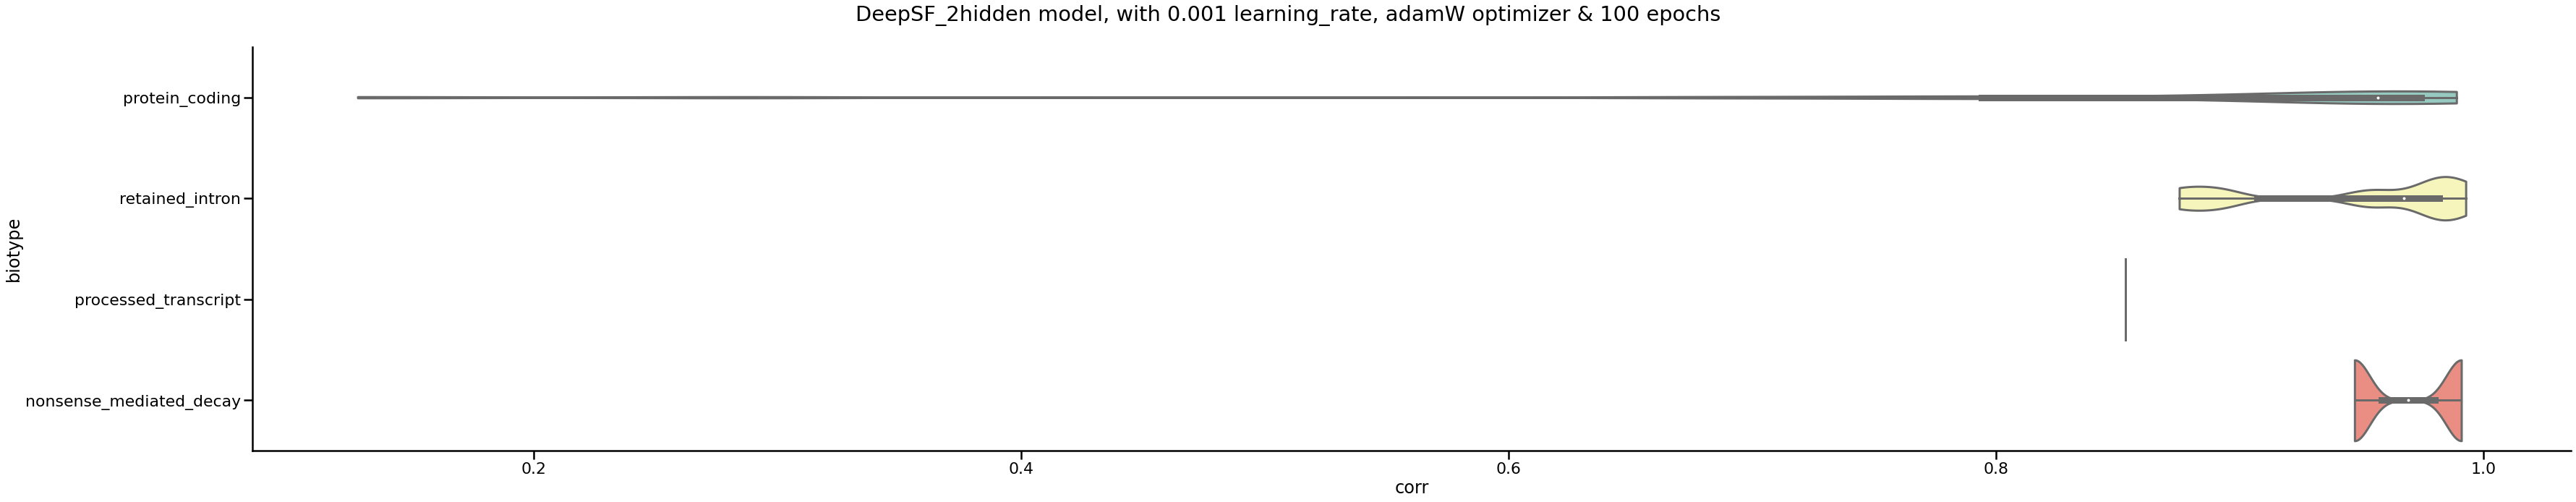

<Figure size 800x800 with 0 Axes>

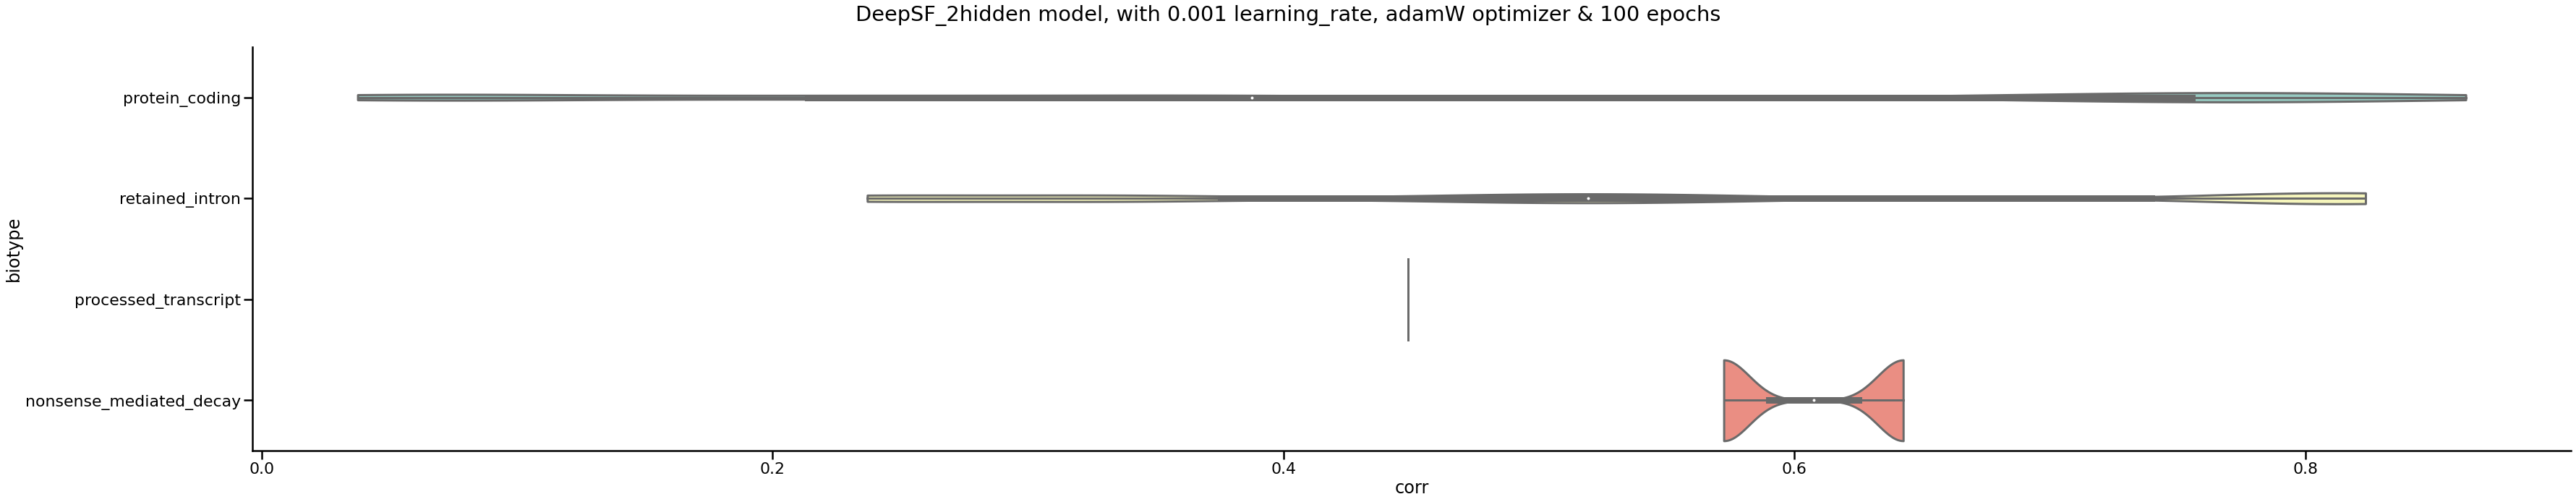

In [6]:
print(config.get_config(), '\n')

# %%% Get the model
model = utils.get_model(config, data_prep)
optimizer = utils.build_optimizer(model, config.optimizer, config.learning_rate)

# %%% Train
history = utils.fit(config.epochs, 
                            model, 
                            data_prep.train_loader, 
                            data_prep.val_loader, 
                            optimizer=optimizer,
                            hyperparameters = config.get_config(),
                            if_wandb = config.if_wandb,
                            path = PATH_DEEPSF,
                            model_name = 'model_DeepSF_2hidden_adamW.pt')
                   
# %%% Plot results
solution = plots.plot_results(history = history, 
                     scaledTrain_df = data_prep.scaledTrain_df, 
                     train_labels = data_prep.train_labels, 
                     scaled_train_gn = data_prep.scaled_train_gn, 
                     scaledValidation_df = data_prep.scaledValidation_df, 
                     valid_labels = data_prep.valid_labels , 
                     scaled_valid_gn = data_prep.scaled_valid_gn, 
                     model = model, 
                     getBM = data_prep.getBM,
                     if_wandb = config.if_wandb,
                     config = config)
        
if config.if_wandb:
    wandb.finish()

solution.solution_train_cor_total
solution.solution_train_df
solution.solution_val_cor_total
solution.solution_val_df

# %%% Compute attributions
X_test = data_prep.scaledValidation_df
y_test = data_prep.valid_labels
gn_test = data_prep.scaled_valid_gn

df = utils.do_deeplift(model, X_test, gn_test, y_test, data_prep)
df